In [ ]:
import random
import re
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import spacy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from datasets import load_dataset

In [ ]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [ ]:
print("Đang tải dataset VQAv2 từ HuggingFace...")

ds = load_dataset('HuggingFaceM4/VQAv2', split="train[:10%]", trust_remote_code=True)
cols_remove = ["question_type", "answers", "answer_type", "image_id", "question_id"]
ds = ds.remove_columns(cols_remove)
split_ds = ds.train_test_split(test_size=0.1, seed=seed)
train_ds = split_ds["train"]
val_ds = split_ds["test"]

print(f"Số lượng mẫu train: {len(train_ds)}")
print(f"Số lượng mẫu val: {len(val_ds)}")


In [5]:
eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, specials=None):
        self.specials = specials or ['<pad>', '<sos>', '<eos>', '<unk>']
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = defaultdict(int)
        
        # Add special tokens first
        for i, token in enumerate(self.specials):
            self.word2idx[token] = i
            self.idx2word[i] = token
        
        self.unk_idx = self.word2idx['<unk>']
    
    def add_word(self, word):
        self.word_count[word] += 1
    
    def build_vocab(self, min_freq=2):
        # Add words that meet minimum frequency
        idx = len(self.specials)
        for word, count in self.word_count.items():
            if count >= min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
    
    def __getitem__(self, word):
        return self.word2idx.get(word, self.unk_idx)
    
    def __len__(self):
        return len(self.word2idx)

def preprocess_answer(answer):
    """Chuẩn hóa câu trả lời theo VQA evaluation protocol"""
    answer = answer.lower().strip()
    # Loại bỏ dấu câu và normalize
    answer = re.sub(r'[^\w\s]', '', answer)
    # Chuyển số thành text (VQA convention)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine',
        '10': 'ten'
    }
    for num, word in number_map.items():
        answer = answer.replace(num, word)
    return answer

In [6]:
all_answers = []
for sample in train_ds:
    processed_answer = preprocess_answer(sample['multiple_choice_answer'])
    all_answers.append(processed_answer)

# Chỉ giữ lại top 1000 answers phổ biến nhất (VQA convention)
answer_counter = Counter(all_answers)
top_answers = [ans for ans, count in answer_counter.most_common(1000)]
answer_to_idx = {ans: idx for idx, ans in enumerate(top_answers)}
idx_to_answer = {idx: ans for ans, idx in answer_to_idx.items()}

print(f"Số lượng classes (top answers): {len(top_answers)}")
print(f"Top 10 answers: {top_answers[:10]}")

Số lượng classes (top answers): 1000
Top 10 answers: ['yes', 'no', 'one', 'two', 'white', 'three', 'blue', 'red', 'black', 'zero']


In [7]:
from collections import Counter, defaultdict
vocab = Vocabulary()

# Thu thập tất cả từ trong questions
for sample in train_ds:
    question = sample['question']
    tokens = [token.text.lower() for token in eng.tokenizer(question)]
    for token in tokens:
        vocab.add_word(token)

# Build vocabulary với min_freq=2
vocab.build_vocab(min_freq=2)

print(f"Kích thước vocab: {len(vocab)}")

Kích thước vocab: 3530


In [8]:
def tokenize_question(question, max_seq_len):
    tokens = [token.text.lower() for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]
    return sequence

In [9]:
class VQAv2Dataset(Dataset):
    def __init__(self, dataset, answer_to_idx, max_seq_len=20, transform=None):
        self.dataset = dataset
        self.max_seq_len = max_seq_len
        self.transform = transform
        self.answer_to_idx = answer_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        sample = self.dataset[index]
        
        # Load image
        img = sample['image'].convert('RGB')
        if self.transform:
            img = self.transform(img)

        # Process question
        question = sample['question']
        question_tokens = tokenize_question(question, self.max_seq_len)
        question_tensor = torch.tensor(question_tokens, dtype=torch.long)
        
        # Process answer
        answer = preprocess_answer(sample['multiple_choice_answer'])
        if answer in self.answer_to_idx:
            label = self.answer_to_idx[answer]
        else:
            label = -1  # Ignore index for answers not in top 1000
        
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return img, question_tensor, label_tensor

In [10]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.RandomCrop(size=224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [11]:
train_dataset = VQAv2Dataset(
    train_ds,
    answer_to_idx,
    transform=data_transform['train']
)

val_dataset = VQAv2Dataset(
    val_ds,
    answer_to_idx,
    transform=data_transform['val']
)

# Custom collate function để xử lý ignored labels
def collate_fn(batch):
    images, questions, labels = zip(*batch)
    
    # Filter out samples with ignored labels (-1)
    valid_indices = [i for i, label in enumerate(labels) if label != -1]
    
    if len(valid_indices) == 0:
        return None, None, None
    
    images = torch.stack([images[i] for i in valid_indices])
    questions = torch.stack([questions[i] for i in valid_indices])
    labels = torch.stack([labels[i] for i in valid_indices])
    
    return images, questions, labels

train_batch_size = 128
val_batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

In [12]:
class VQAModel(nn.Module):
    def __init__(self, n_classes, vocab_size, img_model_name, embedding_dim, 
                 n_layers, hidden_size=512, drop_p=0.3):
        super(VQAModel, self).__init__()
        
        # Image encoder
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=0  # Remove classifier head
        )
        img_features = self.image_encoder.num_features
        
        # Question encoder
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=drop_p if n_layers > 1 else 0
        )
        
        # Fusion layers
        lstm_output_size = hidden_size * 2  # Bidirectional
        self.img_projection = nn.Linear(img_features, hidden_size)
        self.text_projection = nn.Linear(lstm_output_size, hidden_size)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(hidden_size, n_classes)
        )

    def forward(self, img, text):
        # Encode image
        img_features = self.image_encoder(img)
        img_features = self.img_projection(img_features)
        
        # Encode question
        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)
        text_features = lstm_out[:, -1, :]  # Take last output
        text_features = self.text_projection(text_features)
        
        # Fusion
        combined = torch.cat((img_features, text_features), dim=1)
        
        # Classification
        output = self.classifier(combined)
        
        return output

In [13]:
n_classes = len(top_answers)
vocab_size = len(vocab)
img_model_name = 'resnet50'
hidden_size = 512
n_layers = 2
embedding_dim = 300
drop_p = 0.3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    vocab_size=vocab_size,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

print(f"Model được khởi tạo trên device: {device}")
print(f"Tổng số parameters: {sum(p.numel() for p in model.parameters()):,}")


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model được khởi tạo trên device: cuda
Tổng số parameters: 36,812,512


In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    losses = []
    
    with torch.no_grad():
        for batch in dataloader:
            if batch[0] is None:  # Skip empty batches
                continue
                
            images, questions, labels = batch
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)
            
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = sum(losses) / len(losses) if losses else 0
    accuracy = correct / total if total > 0 else 0
    
    return avg_loss, accuracy

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    batch_losses = []
    
    for batch_idx, batch in enumerate(train_loader):
        if batch[0] is None:  # Skip empty batches
            continue
            
        images, questions, labels = batch
        images, questions, labels = images.to(device), questions.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    return sum(batch_losses) / len(batch_losses) if batch_losses else 0

def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 30)
        
        # Training
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if scheduler:
            scheduler.step()
        
    return train_losses, val_losses, val_accs

In [15]:
lr = 1e-4
epochs = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [16]:
print("Bắt đầu training...")
train_losses, val_losses, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Bắt đầu training...

Epoch 1/50
------------------------------
Batch 0, Loss: 6.9039
Batch 100, Loss: 4.2808
Batch 200, Loss: 4.1845
Train Loss: 4.4801
Val Loss: 4.1539, Val Acc: 0.2174

Epoch 2/50
------------------------------
Batch 0, Loss: 4.0208
Batch 100, Loss: 3.7837
Batch 200, Loss: 4.1017
Train Loss: 4.2170
Val Loss: 3.9233, Val Acc: 0.2228

Epoch 3/50
------------------------------
Batch 0, Loss: 3.7660
Batch 100, Loss: 3.2958
Batch 200, Loss: 3.2526
Train Loss: 3.3439
Val Loss: 2.8624, Val Acc: 0.3088

Epoch 4/50
------------------------------
Batch 0, Loss: 3.0307
Batch 100, Loss: 3.1155
Batch 200, Loss: 2.6980
Train Loss: 2.8586
Val Loss: 2.6824, Val Acc: 0.3263

Epoch 5/50
------------------------------
Batch 0, Loss: 2.8375
Batch 100, Loss: 2.7100
Batch 200, Loss: 3.0036
Train Loss: 2.6713
Val Loss: 2.5884, Val Acc: 0.3329

Epoch 6/50
------------------------------
Batch 0, Loss: 2.6792
Batch 100, Loss: 2.6807
Batch 200, Loss: 2.2966
Train Loss: 2.5219
Val Loss: 2.4841, 


Final Results:
Validation Accuracy: 0.4062
Validation Loss: 2.8231


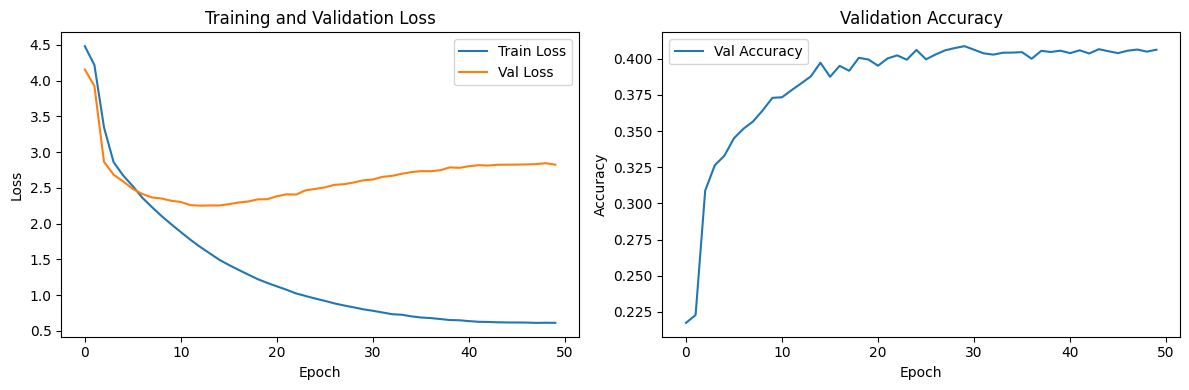

In [ ]:
final_val_loss, final_val_acc = evaluate(model, val_loader, criterion, device)
print(f'\nFinal Results:')
print(f'Validation Accuracy: {final_val_acc:.4f}')
print(f'Validation Loss: {final_val_loss:.4f}')
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()